In [26]:
import os
os.environ['MKL_NUM_THREADS'] = "8"
os.environ['OMP_NUM_THREADS'] = "8"
# os.environ['CUDA_VISIBLE_DEVICES']=""

In [27]:
# imports all necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, Add, Activation, Concatenate, BatchNormalization
from tensorflow.signal import fft2d as fft2, ifft2d as ifft2 

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:85: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:86: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: RuntimeWarning: overflow encountered in exp
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in multiply


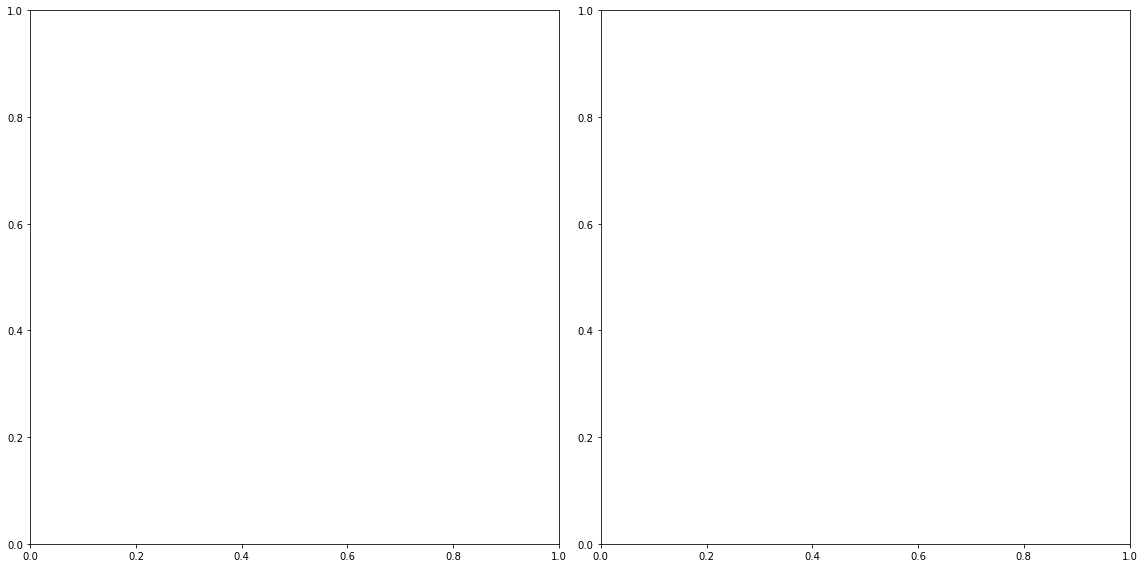

In [172]:
# combined python version of qg2p_bci.m and qg2p_ps_step.m
# initializes, time steps and plots 2 layer quasigeostrophic model of ocean turbulence

import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from numpy.fft import fft2, ifft2
import cmocean


def invert(zh1,zh2,a11,a12,a21,a22):
    ph1=a11*zh1+a12*zh2
    ph2=a21*zh1+a22*zh2
    return(ph1, ph2)

def caluv(ph,k,l,trunc):
    u=-np.real(ifft2(1j*l*ph*trunc))
    v=np.real(ifft2(1j*k*ph*trunc))
    return(u,v)

def advect(q,u,v,k,l):
    qdot=1j*k*fft2(u*q)+1j*l*fft2(v*q)
    return(qdot)

# rescales q just for plotting purposes
def rs(q):
    delta2 = np.max(q)-np.min(q)
    if(delta2==0):
        qp=0*q
        qp[0,0]=1
    else:
        qp=(q-np.min(q))/delta2
    return(qp)

# all times in days, all distances in km
f0=8.64 #mean coriolis parameter
beta=1.728e-3 #df/dy at y0 
r=0 #linear friction applied to all scales (maybe just leave at zero?)
rek=0.1 #bottom drag coefficient (i.e. higher rek means stickier psi2)
L=1000 #domain size in x direction
W=1000 #domain size in y direction

dt=1/32 #time step # CAN CHANGE TO 1/32 IF NX,NY=32,32 IN LINE 56
tpl=1/dt #no time steps per day
n_plot = 1 # plot field every n_plot days
tmax=100 #length of simulation in days

num_substeps_per_day = 32
num_total_steps = int(tmax * num_substeps_per_day)

Rd=40 #Rossby baroclinic deformation radius [see below]
delta=0.2 #ratio of mean layer depths (i.e. H1/H2)
U1=20 #upper layers mean shear velocity
U2=0 #lower layer mean shear velocity

kappa=1 #sets strength of damping for high wavenumbers

nx,ny=32,32 #sets number of horizontal grid cells #CHANGE TO 32, 32 IF CODE RUNS TOO SLOWLY ON YOUR MACHINE
dx=L/nx #sets grid spacing accordingly
dy=W/ny

k0x=2*np.pi/L #calculates smallest wavenumbers from domain size
k0y=2*np.pi/W

# initialises k,l to be evenly spaced in fourier space with (k,l)>(k0xmk0y)
kcoord = k0x*np.arange(0, nx/2+1)
kcoord = np.append(kcoord, k0x*np.arange(-nx/2+1, 0))
lcoord = k0y*np.arange(0, ny/2+1)
lcoord = np.append(lcoord, k0y*np.arange(-ny/2+1, 0))

k, l = np.meshgrid(kcoord, lcoord)

F1=1/(Rd**2*(1+delta)) #inverse burger no in upper layer but dimensional
F2=delta*F1 #inverse burger no in lower layer but dimensional

beta1=beta+F1*(U1-U2)
beta2=beta-F2*(U1-U2)

wv2 = k*k + l*l #square amplitude of wave vector at every point in fourier space
#lines below define inverse of qgpv equation matrix
det=wv2*(wv2+F1+F2)

a11=-(wv2+F2)/det;
a12=-F1/det;
a21=-F2/det;
a22=-(wv2+F1)/det;

a11[0,0]=0;
a12[0,0]=0;
a21[0,0]=0;
a22[0,0]=0;

x, y = np.meshgrid(np.arange(1/2, nx)/nx*L-L/2, np.arange(1/2, ny)/ny*W-W/2)

k0 = k0x

amp=0.1 #sets amplitude (in q) of initialised eddies
q1=amp*(2*np.random.rand(nx,ny)-1)
q2=amp*(2*np.random.rand(nx,ny)-1)

frc=np.exp(-kappa*dt*wv2-r*dt) #damps out large wavenumbers

if(nx==128):
    cphi = 0.69*np.pi 
elif(nx==256):
    cphi = 0.715*np.pi 
elif(nx==512):
    cphi = 0.735*np.pi 
else:
    cphi = 0.65*np.pi 

wvx = np.sqrt((k*dx)**2+(l*dy)**2) #amplitude of k . dx

filtr = np.zeros([nx, ny])
filtr = np.exp(-18*(wvx-cphi)**7)*(wvx>cphi)+(wvx<=cphi)
filtr[np.isnan(filtr)]=1

kmax2=((nx/2-1)*k0x)**2
trunc= (wv2<kmax2) #removes structure smaller than a minimum size set by kmax
t=0
tc=0

psimax=[]
ts=[]

qh1=fft2(q1) #fourier transform of q1
qh2=fft2(q2) #fourier transform of q2

dqh1dt_p=0 #initialises time derivatives to zero
dqh2dt_p=0
dt0=dt
dt1=0 #sets time step for finite difference


data=np.zeros([num_total_steps,nx,ny,4]) # save q1, q2, psi1, and psi2 at daily frequency
t_save = 0
k_save=0
q1_ts = np.zeros([nx, ny, tmax])
q2_ts = np.zeros([nx, ny, tmax])
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16, 8), tight_layout=True)

while t<=(tmax-1)+dt/2:
    #filters small structure in fourier space and converts to real space
    q1=np.real(ifft2(qh1*trunc))
    q2=np.real(ifft2(qh2*trunc))
    #calculates ft of psi by inverting qgpv conservation equation
    ph1, ph2 = invert(qh1,qh2,a11,a12,a21,a22)
    
    psi1=np.real(ifft2(ph1))
    psi2=np.real(ifft2(ph2))
    data[t_save,:,:,:] = np.stack((q1,q2,psi1,psi2),axis=-1)
    t_save += 1
    
    #calculates velocities for qgpv advection in real space by taking curl(psi) 
    #in fourier space and transforming back to real
    u1, v1=caluv(ph1,k,l,trunc)
    u2, v2=caluv(ph2,k,l,trunc)
    #plt.imshow(u1)
    #plt.show()

    dqh1dt=-advect(q1,u1+U1,v1,k,l)-beta1*1j*k*ph1
    dqh2dt=-advect(q2,u2+U2,v2,k,l)-beta2*1j*k*ph2+rek*wv2*ph2 #last term is bottom friction
  

    qh1=frc*filtr*(qh1+dt0*dqh1dt+dt1*dqh1dt_p)
    qh2=frc*filtr*(qh2+dt0*dqh2dt+dt1*dqh2dt_p)

    dqh1dt_p=frc*dqh1dt
    dqh2dt_p=frc*dqh2dt

    if (tc==0):
        dt0=1.5*dt
        dt1=-0.5*dt
    tc=tc+1
    t=tc*dt

In [38]:
# path you will save data on (input and output)
path = '/dat1/sathnil19/qgml/'

In [173]:
# split qg loaded data into input and output numpy arrays

output_all_new = np.zeros((1000, 32, 32, 1280))

input_all_new = np.zeros((1000, 32, 32, 4))

for i in range(1000):
    
    i_rand=i
    # saving day 1 and day 20 of psi1 into two separate channels of the input array
    input_all_new[i, :, :, 0]=data[i_rand, :, :, 2] 
    input_all_new[i, :, :, 1]=data[i_rand+640, :, :, 2] 
    # saving day 1 and day 20 of psi2 into two separate channels of the input array
    input_all_new[i, :, :, 2]=data[i_rand, :, :, 3] 
    input_all_new[i, :, :, 3]=data[i_rand+640, :, :, 3] 
    
    # saving day 1 through day 20 of psi1 and psi2 into 640 (20 days based on qg timestep) different channels per layer
    output_all_new[i, :, :, :640] = np.moveaxis(data[i_rand:i_rand+640, :, :, 2], [0,1,2], [2,0,1])
    output_all_new[i, :, :, 640:] = np.moveaxis(data[i_rand:i_rand+640, :, :, 3], [0,1,2], [2,0,1])

In [174]:
# saving data into batches of 10 for more efficient training of data
for i in range(100):
    x = input_all_new[10*(i):10*(i+1),]
    y = output_all_new[10*(i):10*(i+1),]
    np.save(f'path/x_new{i+900}.npy', x)
    np.save(f'path/y_new{i+900}.npy', y)

In [9]:
# this represents invert, caluv and advect functions converted to be computed using tensorflow in model
# inverts qgpv equation - calculating streamfunction from vorticity
def invert(zh1,zh2,a11,a12,a21,a22):
    a11 = tf.cast(a11, tf.complex128)
    a12 = tf.cast(a12, tf.complex128)
    a21 = tf.cast(a21, tf.complex128)
    a22 = tf.cast(a22, tf.complex128)
    ph1=a11*zh1+a12*zh2
    ph2=a21*zh1+a22*zh2
    return(ph1, ph2)
# computes vorticity fields from streamfunction
def caluv(ph,k,l,trunc):
    j = tf.constant(1j, dtype=tf.complex128)
    k = tf.cast(k, tf.complex128)
    l = tf.cast(l, tf.complex128)
    u=-tf.math.real(ifft2(j*l*ph*trunc))
    v=tf.math.real(ifft2(j*k*ph*trunc))
    return(u,v)
# computes advection terms in Fourier space
def advect(q,u,v,k,l):
    j = tf.constant(1j, dtype=tf.complex128)
    k = tf.cast(k, tf.complex128)
    l = tf.cast(l, tf.complex128)
    q = tf.cast(q, tf.complex128)
    u = tf.cast(u, tf.complex128)
    v = tf.cast(v, tf.complex128)
    qdot=j*k*fft2(u*q)+j*l*fft2(v*q)
    return(qdot)

In [8]:
# initializing constants
pi = tf.constant(np.pi)
f0 = 8.64
beta = 1.728e-3
r = 0
rek = 0.1
L = 1000
W = 1000
Rd = 40
delta = 0.1
U1 = 20
U2 = 0
kappa = 1
nx = 32
ny = 32
k0x = 2 * pi / L 
k0y = 2 * pi / W

In [ ]:
# defines grids and parameters for qg equations
F1=1/(Rd**2*(1+delta))
F2=delta*F1
beta1=beta+F1*(U1-U2)
beta2=beta-F2*(U1-U2)
kcoord = k0x*tf.range(0, nx/2+1)
kcoord = tf.concat([kcoord, k0x*tf.range(-nx/2+1, 0)], axis=0)
lcoord = k0y*tf.range(0, ny/2+1)
lcoord = tf.concat([lcoord, k0y*tf.range(-ny/2+1, 0)], axis=0)
k_tf, l_tf = tf.meshgrid(kcoord, lcoord)
wv2_tf = k_tf*k_tf + l_tf*l_tf
trunc = tf.cast(tf.math.real(wv2_tf) < ((nx / 2 - 1) * k0x)**2, tf.complex128)

In [35]:
def combined_loss(lambda_value):
    def custom_loss_tendency_final(y_true, y_pred):
        # equating neural network timestep with qg simulator timestep
        dT = 1/32
        final_loss = tf.constant(0.0, dtype=tf.complex128)
        y_pred = tf.cast(y_pred, tf.complex128)
        y_pred = tf.transpose(y_pred, perm=[0, 3, 1, 2])
        
        # splitting psi1 and psi2 layers
        psi1 = tf.cast(y_pred[:, 640:, :, :], tf.complex128)
        psi2 = tf.cast(y_pred[:, :640, :, :], tf.complex128)
        k = tf.cast(tf.reshape(k_tf, [1,1,32,32]), tf.complex128)
        l = tf.cast(tf.reshape(l_tf, [1,1,32,32]), tf.complex128)
        
        # computes streamfunction and vorticity values in spectral space
        ph1 = fft2(psi1)
        ph2 = fft2(psi2)
        qh1 =  (-(k**2 + l**2) * ph1) + F1*(ph2 - ph1)
        qh2 =  (-(k**2 + l**2) * ph2) + F2*(ph1 - ph2)
        q1=tf.math.real(ifft2(qh1))
        q2=tf.math.real(ifft2(qh2))
        u1, v1=caluv(ph1,k,l,trunc)
        u2, v2=caluv(ph2,k,l,trunc)
        j = tf.constant(1j, dtype=tf.complex128)
        wv2 = (k * k)+ (l * l)
        
        # finds qg tendencies for upper layer and lower layer
        dq1dt_qg=tf.math.real(ifft2(-advect(q1,u1+U1,v1,k,l)-beta1*j*k*ph1))
        dq2dt_qg=tf.math.real(ifft2(-advect(q2,u2+U2,v2,k,l)-beta2*j*k*ph2+rek*wv2*ph2))
        

        # finds time derivatives for upper and lower layer
        dq1dt_time = tf.math.real((q1[:, 1:, :, :] - q1[:, :-1, :, :])/dT)
        dq2dt_time = tf.math.real((q2[:, 1:, :, :]- q2[:, :-1, :, :])/dT)

        # compares time derivatives and qg tendencies through finite derivatives for upper and lower layer
        l1 = tf.reduce_mean(tf.square(0.5 * (dq1dt_qg[:, 1:, :, :] + dq1dt_qg[:, :-1, :, :]) - dq1dt_time))
        l2 = tf.reduce_mean(tf.square(0.5 * (dq2dt_qg[:, 1:, :, :] + dq2dt_qg[:, :-1, :, :]) - dq2dt_time))
        
        # adds both upper and lower layer loss to compute PDE residuals
        sum_loss = tf.cast(l1 + l2, tf.float32)
        
        # computes true data loss between predicted and ground truth values
        y_pred = tf.cast(tf.math.real(y_pred), tf.float32)
        y_pred = tf.transpose(y_pred, [0,2,3,1])
        data_loss = tf.reduce_mean(tf.square(y_pred - y_true))
        
        # computes total loss by combining data loss with PDE loss
        # minimizes impact of data loss in learning process
        total_loss = sum_loss + lambda_value * data_loss
        
        return total_loss
    return custom_loss_tendency_final
    
# convolutional neural network base architecture
def create_cnn_model(X_shape, Y_shape):
    x = keras.layers.Input(shape=X_shape)
    y = keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    y = keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(y)
    y = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(y)
    y = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(y)
    y = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(y)
    y = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(y)
    y = keras.layers.Conv2D(1280, (3, 3), activation='linear', padding='same')(y)
    model = keras.models.Model(inputs=x, outputs=y)
    model.compile(loss=custom_loss_tendency_final, optimizer=keras.optimizers.Adam())
    return model

In [41]:
# creates model
model = create_cnn_model(X_shape=(32,32,4), Y_shape=(32,32,1280))
model.compile(loss = combined_loss(0.01), optimizer=keras.optimizers.Adam(learning_rate=1e-4)) 
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 32, 32, 4)]       0         
                                                                 
 conv2d_42 (Conv2D)          (None, 32, 32, 8)         296       
                                                                 
 conv2d_43 (Conv2D)          (None, 32, 32, 16)        1168      
                                                                 
 conv2d_44 (Conv2D)          (None, 32, 32, 32)        4640      
                                                                 
 conv2d_45 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 conv2d_46 (Conv2D)          (None, 32, 32, 128)       73856     
                                                                 
 conv2d_47 (Conv2D)          (None, 32, 32, 64)        7379

In [42]:
# keras data generator
class batch_generator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, datadir = ''):
        'Initialization'
        self.list_IDs = list_IDs
        self.datadir = datadir
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return len(self.list_IDs)

    def __getitem__(self, index):
        'Generate one batch of data'

        # select batch ID
        list_ID = self.list_IDs[index]

        # Generate data
        X, Y = self.__data_generation(list_ID)

        return X, Y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))

    def __data_generation(self, ID):
        'Generates data containing batch_size samples' 

        # Load data
        X = np.load(self.datadir +'x_new' + ID + ".npy")
        Y = np.load(self.datadir +'y_new' + ID + ".npy")
        
        return X, Y

# example usage:

data_dir = ''

# training_dir = 'training/'
# validation_dir = 'validation/'

n_training_batches = 800
n_validation_batches = 1000

training_IDs = [str(i) for i in range(0, n_training_batches)]
validation_IDs = [str(i) for i in range(n_training_batches, n_validation_batches)]

training_generator = batch_generator(training_IDs, data_dir)
validation_generator = batch_generator(validation_IDs, data_dir)

hist = model.fit(training_generator, validation_data = validation_generator, epochs = 20)

Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, 

In [51]:
# predict output based on validation input 
X_val_batch, Y_val_batch = training_generator[0]
Y_predicted=model.predict(X_val_batch)

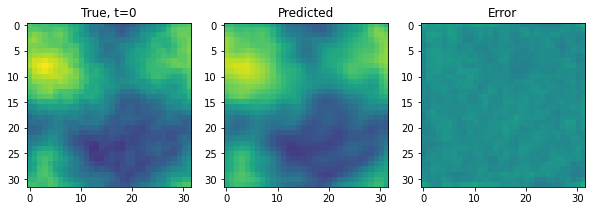

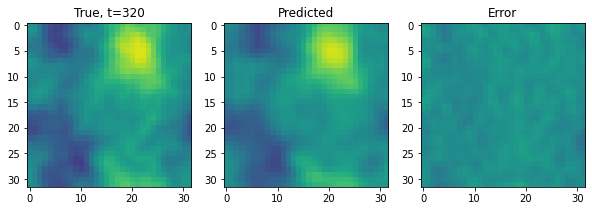

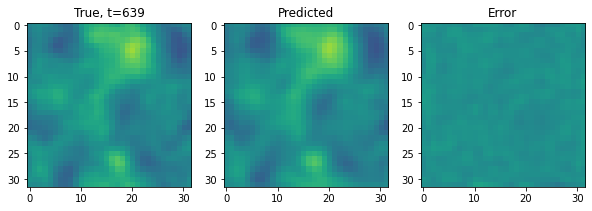

In [53]:
# plotting psi1 at 0, 10, and 19 days
i_rand=random.randint(0,len(Y_predicted))

for i_time in [0,320,639]:
    f, (ax1, ax2, ax3) = plt.subplots(1, 3)
    f.set_figheight(5)
    f.set_figwidth(10)

    ax1.imshow(Y_val_batch[0,:,:,i_time], vmin=-300, vmax=300)
    ax1.set_title('True, t='+str(i_time))

    ax2.imshow(Y_predicted[0,:,:,i_time], vmin=-300, vmax=300)
    ax2.set_title('Predicted')


    ax3.imshow(Y_val_batch[0,:,:,i_time]-Y_predicted[0,:,:,i_time], vmin=-300, vmax=300)
    ax3.set_title('Error')

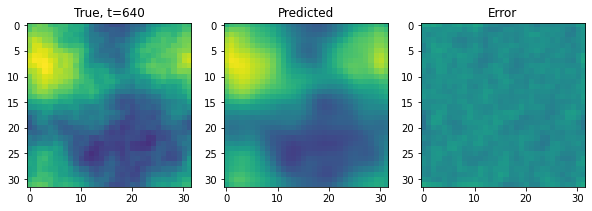

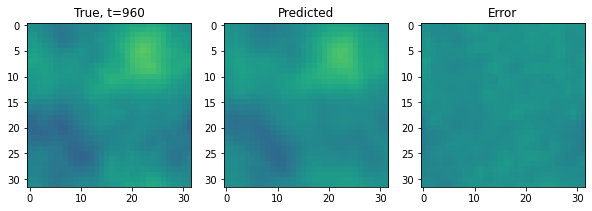

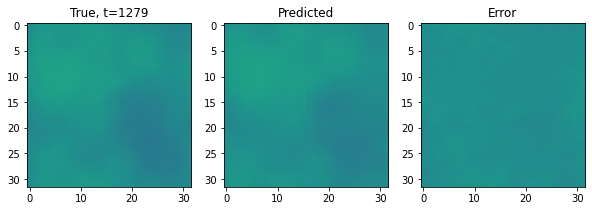

In [54]:
# plotting psi2 at 0, 10, and 19 days
i_rand=random.randint(0,len(Y_predicted))

for i_time in [640,960,1279]:
    f, (ax1, ax2, ax3) = plt.subplots(1, 3)
    f.set_figheight(5)
    f.set_figwidth(10)

    ax1.imshow(Y_val_batch[0,:,:,i_time], vmin=-300, vmax=300)
    ax1.set_title('True, t='+str(i_time))

    ax2.imshow(Y_predicted[0,:,:,i_time], vmin=-300, vmax=300)
    ax2.set_title('Predicted')


    ax3.imshow(Y_val_batch[0,:,:,i_time]-Y_predicted[0,:,:,i_time], vmin=-300, vmax=300)
    ax3.set_title('Error')